## Simulate pseudotime

The first part of this code involves simulating cell states at sampling times. 

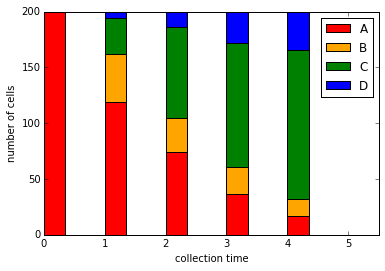

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

lambda1 = 0.5
lambda2 = 1
lambda3 = 0.25

num_cells = 200
num_cell_types = 4
type1_times = np.random.exponential(1/lambda1,num_cells)
type2_times = np.random.exponential(1/lambda2,num_cells)
type3_times = np.random.exponential(1/lambda3,num_cells)

# Determine end states
all_trans_vects = []
for i in range(num_cells):
    all_trans_vects.append([])
    all_trans_vects[i].append((1,type1_times[i]))
    if type2_times[i] < type3_times[i]: 
        all_trans_vects[i].append((2,type1_times[i]+type2_times[i]))
    else: 
        all_trans_vects[i].append((3,type1_times[i]+type3_times[i]))
        
# Count each type of cell at each observation time
def determine_cell_type_at_t(t,trans_vects):
    cell_types = [0]+[i[0] for i in trans_vects]
    cell_type_ind = 0
    for trans in trans_vects:
        if  t > trans[1]:
            cell_type_ind += 1
    return cell_types[cell_type_ind]

obs_times = range(1,5)
type_counts = [np.array([num_cells,0,0,0])]
for i,t in enumerate(obs_times):
    type_counts.append(np.bincount(map(determine_cell_type_at_t,
                                       [t for i in range(num_cells)],all_trans_vects),
                                   minlength=num_cell_types))

# Plot
times = np.array(type_counts).T
bottom=np.zeros(5)
colors=["red","orange","green",'blue']
ctypes=['A','B','C','D']
ind=range(5)
width = 0.35
for i in range(4):
    p1 = plt.bar(ind, times[i], width, color=colors[i],bottom=bottom,label=ctypes[i])
    bottom=bottom+np.array(times[i])
plt.legend()
plt.xlabel('collection time')
plt.ylabel('number of cells')
plt.xlim([0,5.5])
plt.savefig('../deliverables/Fig2.png',dpi=200)

## Estimating rate parameters
If we know the state of each cell at each of 5 sampling points, and we know the underlying chain model, can we estimate the exponential rate parameters underpinning transition rates?

In [58]:
import scipy.optimize

def normalize(X):
    X = X.astype(float)
    X=X.T
    s = np.sum(X,axis=1)
    X = X / s[:,None]
    return X.T

def estimate_rate_parameters_for_Y(times,t):
    times = normalize(times)
    
    # Estimate lambda1
    est_l1 = []
    for i in range(1,len(times[0])):
        est_l1.append(-np.log(float(times[0][i])/times[0][0])/t[i])
    l1 = np.median(est_l1)
    print l1
    # Estimate lambda2 + lambda3
    est_l2,est_l3 = [],[]
    for i in range(1,len(times[0])):
        c = float(times[1][i])/times[0][0]
        def F(x):
            return l1*np.exp(-x*t[i])*(np.exp(t[i]*(-l1+x))-1)/(-l1+x)-c
        b = scipy.optimize.broyden1(F,0.25,f_tol=1e-14)
        a = float(times[2][i])/times[3][i]
        est_l3.append(b/(a+1))
        est_l2.append(a*b/(a+1))
    l2 = np.median(est_l2)
    l3 = np.median(est_l3)
    
    return l1, l2, l3

In [59]:
estimate_rate_parameters_for_Y(times,range(5))

0.540830179036


(0.54083017903555564, 1.1125668694760926, 0.25107768569659011)

# Simulate noisy draws from cell types

Again, we assume an underlying "Y" structure.

/home/jessez/anaconda2/lib/python2.7/site-packages/matplotlib/text.py:1857: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


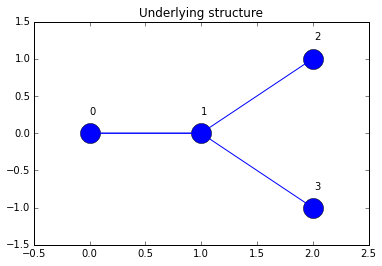

In [4]:
cell_type_means = [(0,0),(1,0),(2,1),(2,-1)]
plt.plot([i[0] for i in cell_type_means],[i[1] for i in cell_type_means],'o',markersize=20)
plt.plot([0,1,2],[0,0,1],'b')
plt.plot([0,1,2],[0,0,-1],'b')
plt.xlim([-0.5, 2.5])
plt.ylim([-1.5,1.5])
plt.title('Underlying structure')

ii = 0
for xy in zip([i[0] for i in cell_type_means], [i[1]+0.25 for i in cell_type_means]):
    plt.annotate('%s' % ii, xy=xy, textcoords='offset points')
    ii += 1

time 0


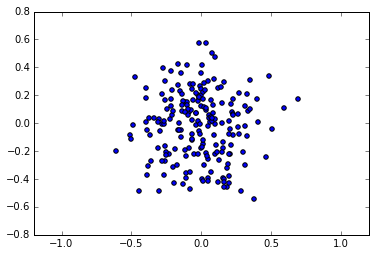

time 1


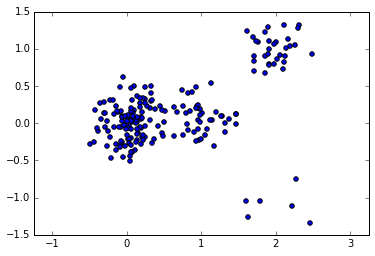

time 2


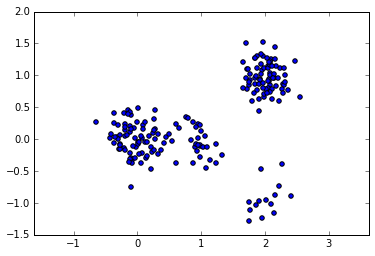

time 3


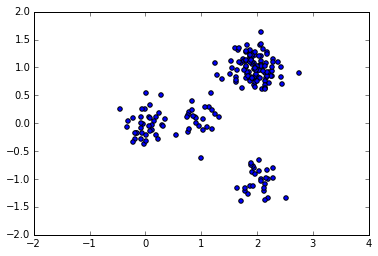

time 4


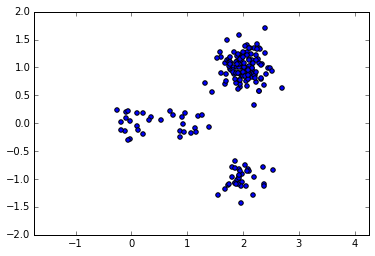

done


In [66]:
from sklearn.decomposition import PCA

def generate_noise(D,n,var):
    mu = np.zeros(D)
    Sigma = var*np.eye(D)
    return np.random.multivariate_normal(mu,Sigma,n)

def generate_noisy_data(types,means,var=0.05):
    samples = np.matrix([0,0])
    D = len(means[0])
    for cell_type,cell_type_count in enumerate(types):
        if cell_type_count > 0:
            type_means = np.array([means[cell_type] for i in range(cell_type_count)])
            samples = np.concatenate((samples,np.asarray(type_means+generate_noise(D,cell_type_count,var))),axis=0)
    return samples[1:,:]

# Plot results!
def pca_and_plot_data(x_set,t_set,plot=True):
    # If vectors are > 2 dimensions, project them to 2 dimensions
    if len(x_set[0][0]) > 2:
        y_set = []
        x_pca = PCA(n_components=2)
        for x in x_set:
            x_pca.fit(x)
            y_set.append(x_pca.transform(x))
    else: y_set = x_set
    
    if plot:
        for i,t in enumerate(t_set):
            print 'time '+str(t)
            plt.scatter(y_set[i][:,0],y_set[i][:,1])
            plt.xlim([-1,3])
            plt.ylim([-2,2])
            plt.axis('equal')
            plt.savefig('../deliverables/Fig3_'+str(int(t))+'.png',dpi=200)
            plt.show()
    return y_set

# Sample types 
samples_set = []
for observations in type_counts:
    samples_set.append(generate_noisy_data(observations,cell_type_means))

pca_and_plot_data(samples_set,range(5))
print 'done'

## Estimate states from data points using EM

In [63]:
import itertools
import networkx as nx

def bin_count_to_labels(bincount):
    labels = []
    for cell,cell_count in enumerate(bincount):
        labels += [cell for i in range(cell_count)]
    return np.array(labels)

def match_labels(label1, label2):
    # Create two dictionaries. Each will store the indices of each label  
    unique_labels1,unique_labels2 = np.unique(label1),np.unique(label2)
    entries1,entries2={},{}
    for label in unique_labels1:
        entries1[label] = set(np.flatnonzero((label1==label)))
    for label in unique_labels2:
        entries2[label] = set(np.flatnonzero((label2==label)))
    # Create an intersection matrix which counts the number of entries that overlap for each label combination    
    intersection_matrix=np.zeros((len(unique_labels1),len(unique_labels2)))
    for ind1,ind2 in itertools.product(range(len(unique_labels1)),range(len(unique_labels2))):
        intersection_matrix[ind1,ind2]=len(entries1[unique_labels1[ind1]].intersection(entries2[unique_labels2[ind2]]))
    # Get mapping of labels                                                                                  
    H = get_max_wt_matching(unique_labels1,unique_labels2,intersection_matrix)
    new_labels = np.copy(label1)
    for label in unique_labels1:
        new_labels[label1 == label] = H[label]-len(unique_labels1)
    return new_labels
                                                               
def get_max_wt_matching(row_label,column_label, weight_matrix):
    G = nx.complete_bipartite_graph(len(row_label), len(column_label))
    for u,v in G.edges():
        G[u][v]["weight"]=weight_matrix[u,v-len(row_label)]
    H=nx.max_weight_matching(G)
    return H

time 0


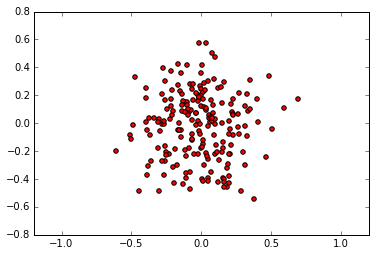

time 1


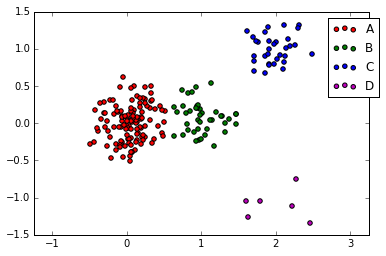

time 2


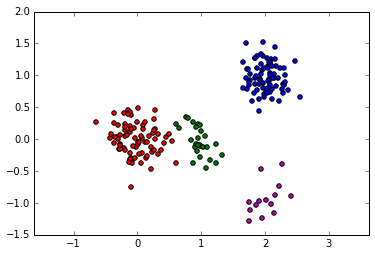

time 3


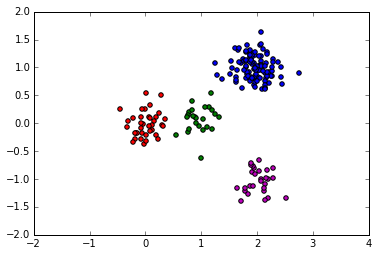

time 4


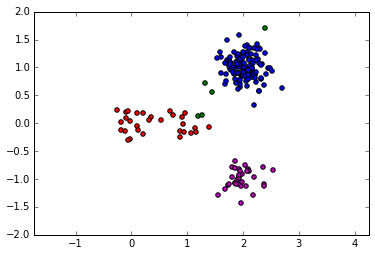

In [67]:
from sklearn import mixture

def EM_classifer(data,k):
    clf = mixture.GMM(n_components=k, covariance_type='full')
    clf.fit(data)
    return clf.predict(data)

times_EM = []
for i in range(5):
    print 'time '+str(i)
    labels_true = bin_count_to_labels(type_counts[i])
    labels = match_labels(EM_classifer(samples_set[i],np.sum(type_counts[i] != 0)),labels_true)
    times_EM.append(np.bincount(labels,minlength=4))
    c = ['r','g','b','m']
    for j in range(4):
        plt.scatter(samples_set[i][labels==j,0],
                    samples_set[i][labels==j,1],c=c[j],label=ctypes[j])
    plt.xlim([-1,3])
    plt.ylim([-2,2])
    plt.axis('equal')
    if i == 1: plt.legend(bbox_to_anchor=(1.05, 1))
    plt.savefig('../deliverables/Fig4_'+str(int(i))+'.png',dpi=200)
    plt.show()
times_EM = np.array(times_EM).T

In [68]:
estimate_rate_parameters_for_Y(times_EM,range(5))

0.492552809994


(0.49255280999373052, 1.2860453413803126, 0.26539057968320978)

## Test on Trapnell's data

time 0.0


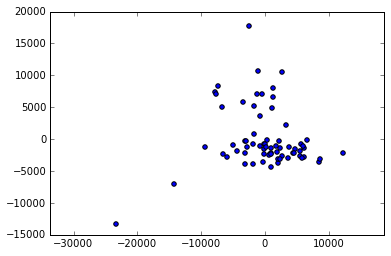

time 24.0


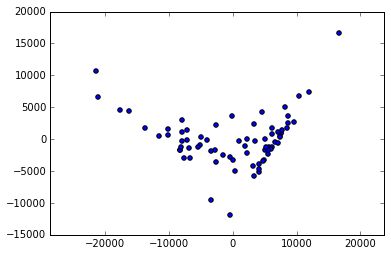

time 48.0


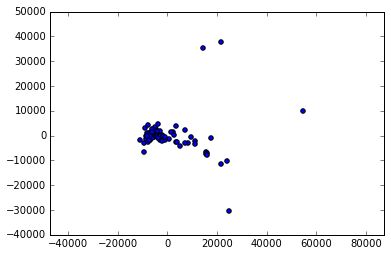

time 72.0


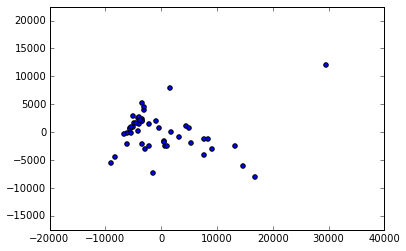

In [70]:
X = np.loadtxt('../data/HSMM_expressions.txt').T
obs_times = np.loadtxt('../data/HSMM_metadata_hours.txt')

times = np.sort(np.unique(obs_times))
samples_set_Trap = []
for t in times:
    samples_set_Trap.append(X[obs_times == t,:])
    
x_pca = pca_and_plot_data(samples_set_Trap,times)

time 0.0


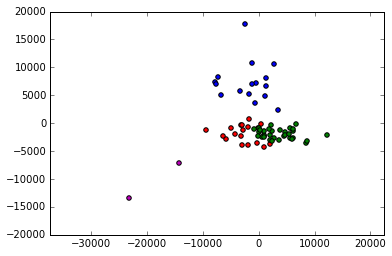

time 24.0


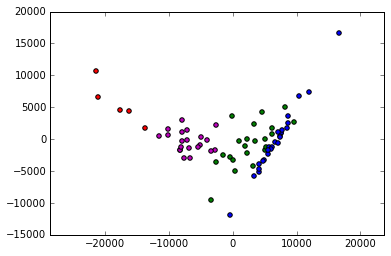

time 48.0


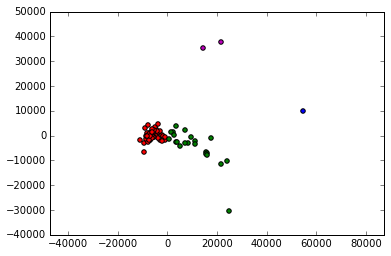

time 72.0


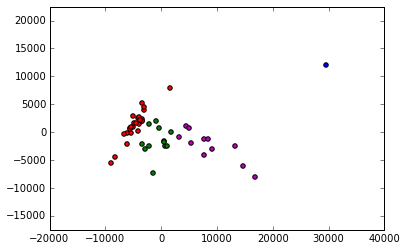

CPU times: user 6.19 s, sys: 30.2 s, total: 36.4 s
Wall time: 1.67 s


In [10]:
%%time
times_EM = []
for i,t in enumerate(times):
    print 'time '+str(t)
    labels = EM_classifer(x_pca[i],4)
    times_EM.append(np.bincount(labels,minlength=4))
    c = ['r','g','b','m']
    for j in range(4):
        plt.scatter(x_pca[i][labels==j,0],
                    x_pca[i][labels==j,1],c=c[j])
    plt.xlim([-1,3])
    plt.ylim([-2,2])
    plt.axis('equal')
    plt.show()
times_EM = np.array(times_EM).T

In [31]:
estimate_rate_parameters_for_Y(times_EM,times)

-0.0291551244182


/home/jessez/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in divide


ValueError: total size of new array must be unchanged

## Unanswered questions

1. What if the structure isn't known?
2. What if variance different for different states?
3. What accuracy guarantees can we get depending on # samples, complexity of underlying tree?